In [2]:
"""
Created on Thu Sep 13 13:27:03 2018

@author: Peng Wang

Build GBM and Random Forest trees to predict hourly and daily bike share in downtown Vancouver
Collected data from:
- Historical bike rental data from Mobi website (https://www.mobibikes.ca/en/system-data)
- Statutory holidays: OfficeHolidays (https://www.officeholidays.com/)
- Weather information from Air Data Archive (https://www2.gov.bc.ca/gov/content/environment/air-land-water/air/air-quality/current-air-quality-data/bc-air-data-archive) by BC Government

Temperature: provided in the original data
Other weather info and air quality: BC Air Data Archive https://www2.gov.bc.ca/gov/content/environment/air-land-water/air/air-quality/current-air-quality-data/bc-air-data-archive
Used observations from YVR monitoring station, instead of Vancouver Harbour station which doe not have air quality or wind speed
"""

import pandas as pd
import numpy as np
import glob, pickle 
from datetime import date, timedelta, datetime
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error # import metrics from sklearn
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator

In [3]:
sns.set()
# Date range 1/1/2013 - 08/31/2018. Use 08/25-08/31/2018 for testing.
BEGIN_DATE = date(2017,1,1)
END_DATE = date(2018,7,31)
TEST_START_DATE = date(2018,7,25)
TEST_END_DATE = date(2018,7,31)
PATH_DATA = r'./data/' 
PATH_MODEL = r'./models/' 
FN_WEATHER = r'Weather_YVR_20170101_20180731.csv'
FN_HOLIDAY_BC = r'holidays_bc.csv'
FN_SAVED_MODEL = r'bike_rental_xgb.model'
FN_SAVED_PREDICTIONS = r'predictions.csv'

In [4]:
# Load bike share data
data_files = glob.glob(PATH_DATA + "Mobi*.xlsx")
data_orig = pd.DataFrame()
list_ = []
for file_ in data_files:
    df = pd.read_excel(file_)
    list_.append(df)
data_orig = pd.concat(list_, ignore_index=True, sort=False)
# Add/extrac datetime related features
data_orig['Date'] = data_orig['Departure'].dt.date
data_orig = data_orig[(BEGIN_DATE<=data_orig['Date']) & (data_orig['Date']<=END_DATE)]
data_orig['Year'] = data_orig['Departure'].dt.year
data_orig['Month'] = data_orig['Departure'].dt.month
data_orig['DayOfMonth'] = data_orig['Departure'].dt.day
data_orig['DayOfWeek'] = data_orig['Departure'].dt.dayofweek
data_orig['HourOfDay'] = data_orig['Departure'].dt.hour
seasons = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer', 7:'Summer', 8:'Summer', 
           9:'Autumn', 10:'Autumn', 11:'Autumn', 12:'Winter'}
data_orig['Season'] = [seasons[x] for x in data_orig['Month'].values]

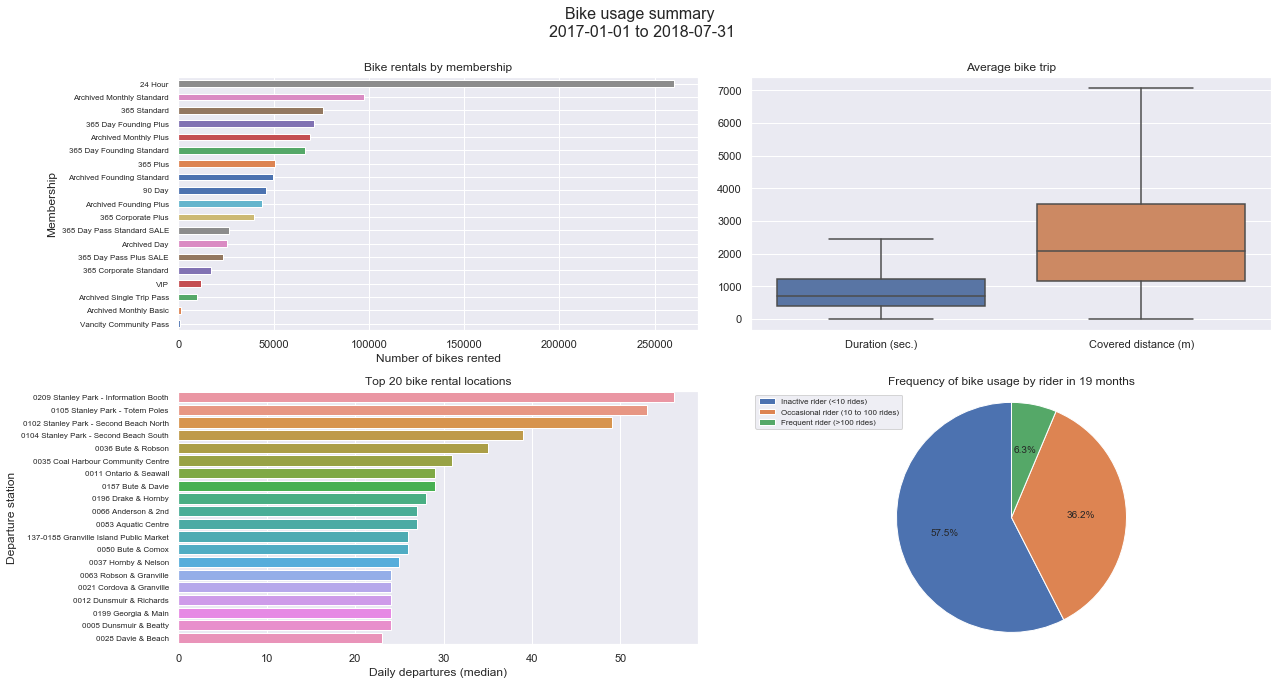

In [5]:
# -----------  Data visualization ----------
# Bike usage summary
fig, axes = plt.subplots(2,2,figsize=(18,10))
fig.suptitle('Bike usage summary \n{} to {}'.format(BEGIN_DATE, END_DATE),fontsize=16)
data_orig.loc[data_orig['Membership type']=='Single Trip Pass', 'Membership type'] = 'Archived Single Trip Pass'
ax = data_orig['Membership type'].value_counts(ascending=True).plot.barh(ax=axes[0,0])
ax.set_ylabel('Membership')
ax.set_xlabel('Number of bikes rented')
ax.set_yticklabels(ax.get_yticklabels(),size=8)
ax.set_title('Bike rentals by membership', fontsize=12)
ax = sns.boxplot(x='variable', y='value', data=pd.melt(data_orig[['Duration (sec.)','Covered distance (m)']]), 
            showfliers=False, ax=axes[0,1])
ax.set_title('Average bike trip', fontsize=12)
ax.set_ylabel('')
ax.set_xlabel('')
stations = data_orig.groupby(['Departure station','Date'], as_index=False).agg({'Departure':'count'}).groupby('Departure station', as_index=False).agg({'Departure':'median'})
stations.rename(columns={'Departure':'Daily departures (median)'}, inplace=True)
ax = sns.barplot(y='Departure station', x='Daily departures (median)', 
            data=stations.sort_values(by='Daily departures (median)', ascending=False).head(20), 
            orient ='h', ax=axes[1,0])
ax.set_yticklabels(ax.get_yticklabels(),size=8)
ax.set_title('Top 20 bike rental locations', fontsize=12)
riders = pd.DataFrame(data_orig['Account'].value_counts(ascending=False))
#riders.describe()
#riders: inactive <= 10, occasional < 100, freq >= 100
riders['Category'] = riders['Account'].apply(lambda x: 'Freq' if x>100 else 'Inactive' if x<10 else 'Occasional')
ax = riders['Category'].value_counts().plot.pie(startangle=90, labels=None, autopct='%1.1f%%', textprops={'fontsize': 10}, ax=axes[1,1])
ax.legend(loc=2, labels=['Inactive rider (<10 rides)', 'Occasional rider (10 to 100 rides)', 'Frequent rider (>100 rides)'], prop={'size':8})
ax.axis('equal')
ax.set_title('Frequency of bike usage by rider in 19 months', fontsize=12)
ax.set_ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

In [6]:
# Get BC holidays
# Data from https://www.officeholidays.com/
holidays_bc = pd.read_csv(PATH_DATA+FN_HOLIDAY_BC)
holidays_bc.rename(columns={'Holiday':'Holiday_bc'}, inplace=True)
holidays_bc['Date'] = pd.to_datetime(holidays_bc['Date']).dt.date
data_orig_merged = pd.merge(data_orig, holidays_bc[['Date','Holiday_bc']], how='left', on='Date')
data_orig_merged['Holiday_bc'].fillna('', inplace=True)

In [7]:
# Get weather info
weather_vancouver = pd.read_csv(PATH_DATA+FN_WEATHER)
# Remove extra spaces from header
weather_vancouver.rename(columns=lambda x: x.strip(), inplace=True)
# Remove extra spaces from columns
weather_vancouver[weather_vancouver.columns] = weather_vancouver.apply(lambda x: x.str.strip())
# Change midnight datetime to same format as data_orig
midnight = weather_vancouver[weather_vancouver['Date Time'].str.contains('24:00')]['Date Time']
midnight_date = pd.to_datetime(midnight.str.split(expand=True)[0]) + timedelta(1)
weather_vancouver.loc[midnight.index, 'Date Time'] = midnight_date.astype(str)
weather_vancouver['Date Time'] = pd.to_datetime(pd.to_datetime(weather_vancouver['Date Time']).dt.strftime('%Y/%m/%d %H:%M:%S'))
# Missing entry for the first hour of the first day - copy the next entry
weather_vancouver = pd.concat([weather_vancouver.head(1), weather_vancouver], axis=0, ignore_index=True)
# Update to the correct time i.e. 00:00:00
weather_vancouver.loc[0, 'Date Time'] = weather_vancouver.loc[0, 'Date Time'] + timedelta(hours=-1)
# Merge with bike share data i.e. data_orig_merged
weather_vancouver.rename(columns={'Date Time':'Departure'}, inplace=True)
data_orig_merged = pd.merge(data_orig_merged, weather_vancouver[['Departure','PM25','WSPD_SCLR','PRECIP_TOTAL']], how='left', on='Departure')
# Replace all empty values with 0.0
data_orig_merged[['PM25','WSPD_SCLR','PRECIP_TOTAL']] = data_orig_merged[['PM25','WSPD_SCLR','PRECIP_TOTAL']].replace({'':0.0})
data_orig_merged[['PM25','WSPD_SCLR','PRECIP_TOTAL']] = data_orig_merged[['PM25','WSPD_SCLR','PRECIP_TOTAL']].astype(float)

In [8]:
# Prepare final data set: each row represents the number of bikes rented for a specific hour of a day
data = pd.DataFrame()
data = data_orig_merged.groupby(['Year','Month','DayOfMonth','HourOfDay'], as_index=False).agg(
                       {'Departure':'count','Date':'first',
                        'DayOfWeek':'first','Departure temperature (°C)':'mean',
                        'Holiday_bc':'first', 'Season':'first','PM25':'first',
                        'WSPD_SCLR':'first','PRECIP_TOTAL':'first'})
data.rename(columns={'Departure':'Number of bikes rented', 
                     'Departure temperature (°C)':'Temperature',
                     'WSPD_SCLR':'WindSpeed',
                     'PRECIP_TOTAL':'Precipitation'}, inplace=True)

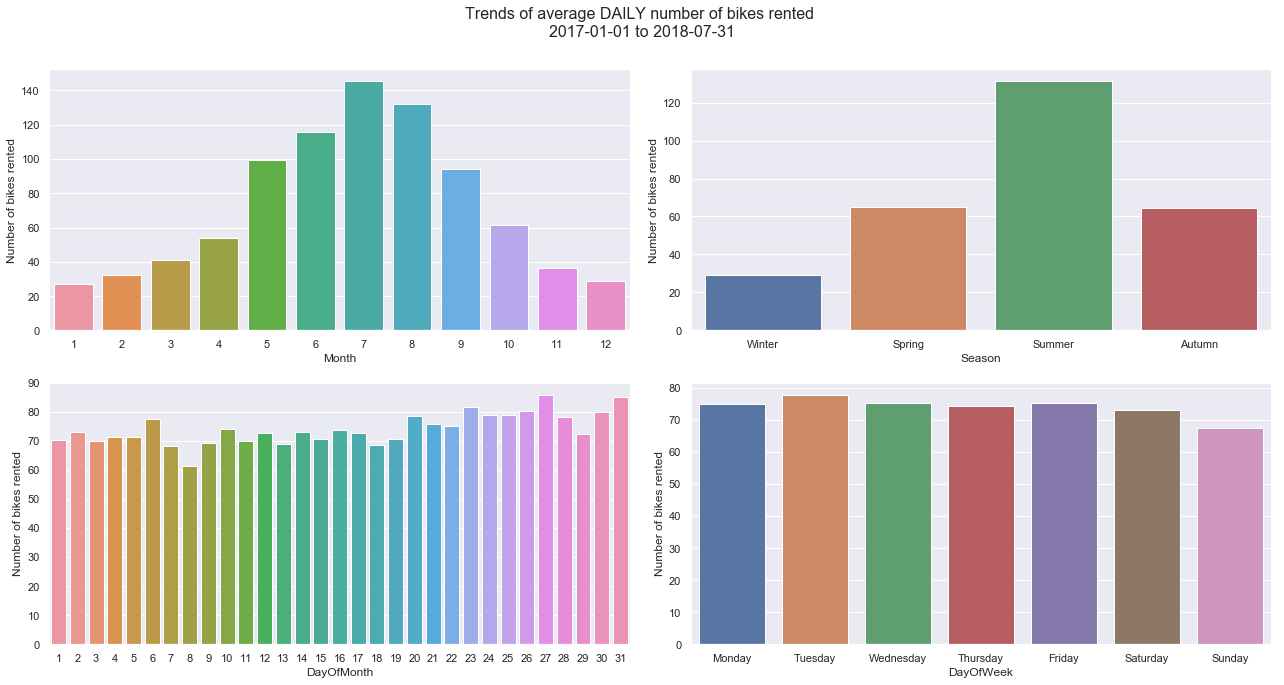

In [10]:
# -----------  Data visualization ----------
# Trend analysis
fig, axes = plt.subplots(2,2,figsize=(18,10))
fig.suptitle('Trends of average DAILY number of bikes rented \n{} to {}'.format(BEGIN_DATE, END_DATE),fontsize=16)
sns.barplot(x='Month', y='Number of bikes rented', estimator=np.mean, data=data, ci=None, ax=axes[0,0])
sns.barplot(x='Season', y='Number of bikes rented', estimator=np.mean, data=data, ci=None, ax=axes[0,1])
sns.barplot(x='DayOfMonth', y='Number of bikes rented', estimator=np.mean, data=data, ci=None, ax=axes[1,0])
sns.barplot(x='DayOfWeek', y='Number of bikes rented', estimator=np.mean, data=data, ci=None, ax=axes[1,1])
axes[1,1].set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

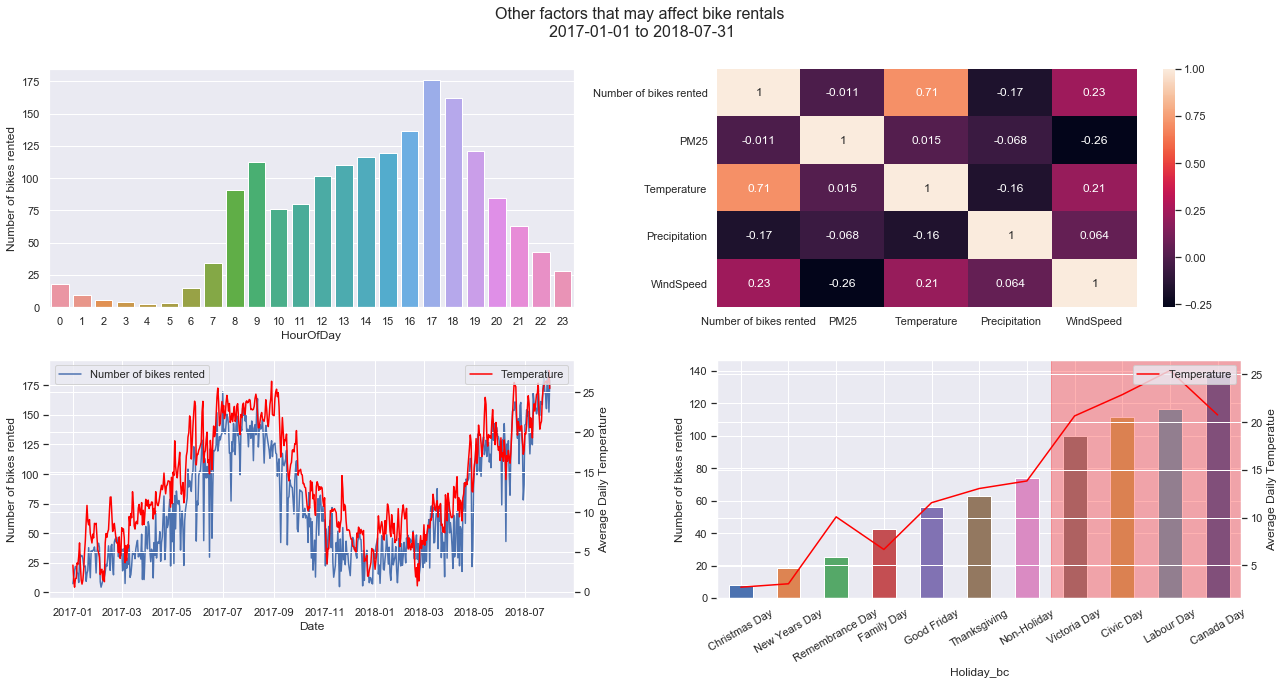

In [11]:
# Correlation analysis 
fig, axes = plt.subplots(2,2,figsize=(18,10))
fig.suptitle('Other factors that may affect bike rentals \n{} to {}'.format(BEGIN_DATE, END_DATE),fontsize=16)
sns.barplot(x='HourOfDay', y='Number of bikes rented', estimator=np.mean, data=data, ci=None, ax=axes[0,0])
sns.heatmap(data[['Number of bikes rented','PM25','Temperature','Precipitation','WindSpeed']].corr(), annot=True, ax=axes[0,1])
# Plot trend lines of daily number of bikes rented and temperature
ax1 = data.groupby(['Date'])['Number of bikes rented'].mean().plot(ax=axes[1,0])
ax1.set_ylabel('Number of bikes rented')
ax1.legend(loc=0)
ax2 = ax1.twinx()
ax2.set_ylabel('Average Daily Temperature')
data.groupby(['Date'])['Temperature'].mean().plot(ax=ax2, color='red')
ax2.legend(loc=1)
bikes_holiday = data.groupby('Holiday_bc').agg({'Number of bikes rented':'mean','Temperature':'mean'}).sort_values('Number of bikes rented').reset_index()
bikes_holiday.loc[bikes_holiday['Holiday_bc']=='', 'Holiday_bc'] = 'Non-Holiday'
bikes_holiday.set_index('Holiday_bc', inplace=True, drop=True)
ax1 = bikes_holiday['Number of bikes rented'].plot.bar(ax=axes[1,1])
ax1.set_ylabel('Number of bikes rented')
ax2 = ax1.twinx()
ax2.set_ylabel('Average Daily Temperatue')
line2 = bikes_holiday['Temperature'].plot(ax=ax2, color='red')
line2.legend(loc=1)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=30)
axes[1,1].axvspan(6.5, 11, color='red', alpha=0.3)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

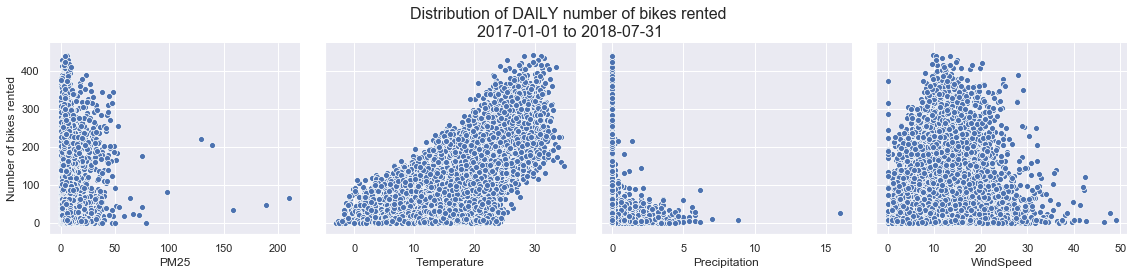

In [12]:
ax = sns.pairplot(data, x_vars=['PM25','Temperature','Precipitation','WindSpeed'], y_vars=['Number of bikes rented'], height=4)
ax.fig.suptitle('Distribution of DAILY number of bikes rented \n{} to {}'.format(BEGIN_DATE, END_DATE),fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])

In [13]:
# Convert categorical columns
data = pd.get_dummies(data, columns=['Holiday_bc','Season'])
# Drop PM25 and WindSpeed as they do not appear to contribute prediction on bike rentals
data.drop(columns=['Holiday_bc_','PM25','WindSpeed'], inplace=True)

In [14]:
# ---------------------------------------------------
# ------------- Train Model -------------------------
# ---------------------------------------------------
# *** Split training/test data ***
train_data = data[data['Date'] < TEST_START_DATE]
test_data = data[(data['Date'] >= TEST_START_DATE) & (data['Date'] <= TEST_END_DATE)]
test_data.reset_index(inplace=True, drop=True)
train_data = train_data.drop(['Date'], axis=1)
test_data = test_data.drop(['Date'], axis=1)
train_x = train_data.drop(['Number of bikes rented'], axis=1)
train_y = train_data['Number of bikes rented']
test_x = test_data.drop(['Number of bikes rented'], axis=1)
test_y = test_data['Number of bikes rented']

In [15]:
# *** Random Forest Regression ***
rf_regressor = RandomForestRegressor(random_state=29, n_jobs=-1)
# Random grid search on hyperparameters
cv_sets = ShuffleSplit(random_state = 4) # shuffling for cross-validation
rf_parameters = {'n_estimators':[60, 80, 100], 
                 'min_samples_leaf':[1, 2, 3], 
                 'max_depth':[8, 10, 12],
                 'min_impurity_decrease':[0.0],
                 'min_samples_split':[2]}
scorer = make_scorer(r2_score)
n_iter = 24
rf_grid_search = RandomizedSearchCV(rf_regressor, 
                              rf_parameters, 
                              n_iter = n_iter, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 50)
start = time() # start time
rf_grid_fit = rf_grid_search.fit(train_x, train_y)
rf_best = rf_grid_search.best_estimator_
end = time() # end time
# Calculate training time
rf_time = (end-start)/60.
print('---------------------------------------')
print('Took {0:.2f} minutes to find optimized parameters for RF model'.format(rf_time))
print('Best parameters for RF model: {}'.format(rf_grid_fit.best_params_))
print('---------------------------------------')

---------------------------------------
Took 3.22 minutes to find optimized parameters for RF model
Best parameters for RF model: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_depth': 12}
---------------------------------------


In [16]:
# *** XGBoost Regression ***
xgb_regressor = xgb.XGBRegressor(random_state=29, n_jobs=-1)
cv_sets = ShuffleSplit(random_state = 4) # shuffling for cross-validation
xgb_parameters = {'objective': ['reg:linear'],
                  'n_estimators': [60, 80, 100],
                  'learning_rate': [0.01, 0.01, 0.1, 1],
                  'gamma': [0.01, 0.2, 1.0],
                  'reg_lambda': [0.01, 0.5, 0.1],
                  'max_depth': [5,7,9], # Max depth of tree. Deeper -> overfitting
                  'subsample': [0.5, 0.6, 0.7], # Subsample ratio of training instances
                  'colsample_bytree': [0.6, 0.7, 0.8], # Subsample ratio of columns of each tree
                  'silent': [0] # Printing running msg
                  }
scorer = make_scorer(r2_score)
n_iter = 24
xgb_grid_search = RandomizedSearchCV(xgb_regressor, 
                              xgb_parameters, 
                              n_iter = n_iter, 
                              scoring = scorer, 
                              cv = cv_sets,
                              verbose=1,
                              random_state= 50)
start = time() # start time
xgb_grid_fit = xgb_grid_search.fit(train_x, train_y)
xgb_best = xgb_grid_search.best_estimator_
end = time() # end time
# Calculate training time
xgb_time = (end-start)/60.
print('---------------------------------------')
print('Took {0:.2f} minutes to find optimized parameters for XGB model'.format(xgb_time))
print('Best parameters for XGB model: {}'.format(xgb_grid_fit.best_params_))
print('---------------------------------------')

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.1min finished


---------------------------------------
Took 2.15 minutes to find optimized parameters for XGB model
Best parameters for XGB model: {'subsample': 0.5, 'silent': 0, 'reg_lambda': 0.1, 'objective': 'reg:linear', 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.8}
---------------------------------------


In [17]:
# ---------------------------------------------------
# ------------- Prediction -------------------------
# ---------------------------------------------------
# Prediction using RF
rf_preds = rf_best.predict(test_x).astype(int) # Convert fractions to whole numbers
# RF R2-score and MSLE
rf_r2 = r2_score(test_y, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_preds))
# Prediction using XGB
xgb_preds = xgb_best.predict(test_x).astype(int) # Convert fractions to whole numbers
xgb_r2 = r2_score(test_y, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_preds))
# Compare the scores
regres_perform = {'R2': [rf_r2,xgb_r2],
                  'RMSE': [rf_rmse,xgb_rmse]} 
index_name = ['RF', 'XGB']
regres_perform = pd.DataFrame(data=regres_perform, index=index_name)
regres_perform

,R2,RMSE
RF,0.918504,35.992807
XGB,0.919839,35.696638


Text(0.5,0,'Hour of the day')

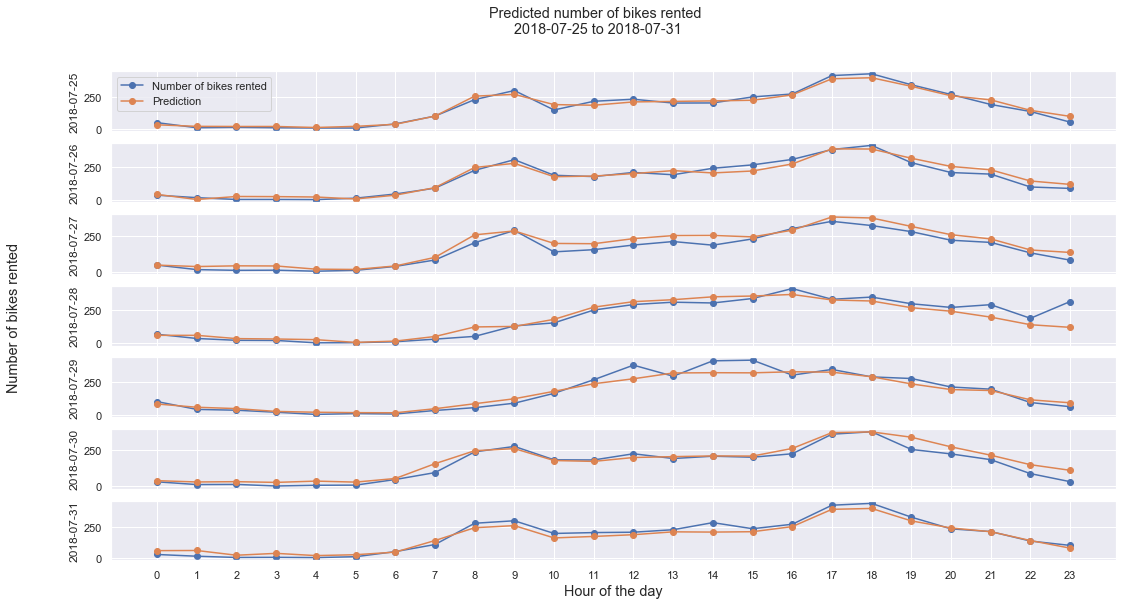

In [18]:
# Visualize XGBoost prediction
pred = pd.concat([test_data, pd.DataFrame({'Prediction':xgb_preds})], axis=1)
NUM_SUBPLOTS = TEST_END_DATE.day - TEST_START_DATE.day + 1
fig, axes = plt.subplots(NUM_SUBPLOTS,1, figsize=(18,9),sharex=True)
fig.suptitle('Predicted number of bikes rented \n{} to {}'.format(TEST_START_DATE, TEST_END_DATE))
for i, ax in enumerate(axes):    
    curr_pred = pred.loc[pred['DayOfMonth']==TEST_START_DATE.day + i]
    ax.plot(curr_pred['HourOfDay'], curr_pred['Number of bikes rented'], 'o-')
    ax.plot(curr_pred['HourOfDay'], curr_pred['Prediction'], 'o-')
    ax.set_xticks(curr_pred['HourOfDay'])
    ax.set_ylabel(TEST_START_DATE + timedelta(days=i))    
axes[int(NUM_SUBPLOTS/2)].figure.text(0.05,0.5, "Number of bikes rented", \
    ha="center", va="center", rotation=90, fontsize='large')
axes[0].legend(loc='upper left')
plt.xlabel('Hour of the day', fontsize='large')

Text(0.5,1,'XGB feature importances')

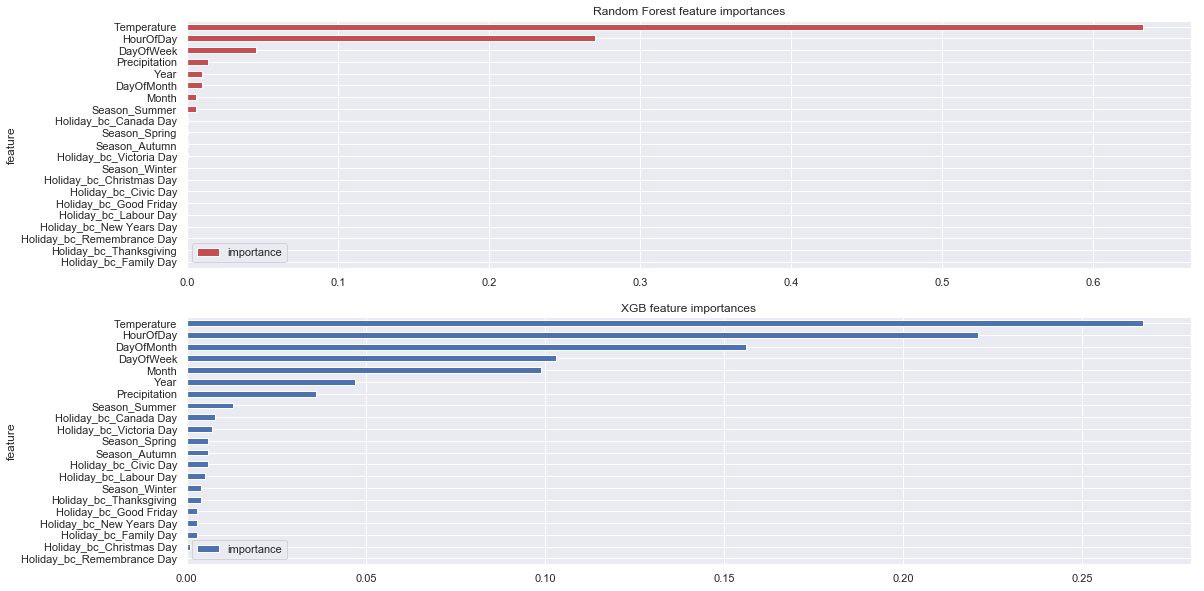

In [19]:
# Plot RF and XGB feature importances
fig, axes = plt.subplots(2,1,figsize=(18,10))
rf_importances = pd.DataFrame({'feature':test_x.columns,'importance':np.round(rf_best.feature_importances_,3)})
rf_importances = rf_importances.sort_values('importance',ascending=True).set_index('feature')
rf_importances.plot.barh(color='r', ax=axes[0])
axes[0].set_title('Random Forest feature importances', fontsize=12)
xgb_importances = pd.DataFrame({'feature':test_x.columns,'importance':np.round(xgb_best.feature_importances_,3)})
xgb_importances = xgb_importances.sort_values('importance',ascending=True).set_index('feature')
xgb_importances.plot.barh(color='b', ax=axes[1])
axes[1].set_title('XGB feature importances', fontsize=12)

In [20]:
# Save prediction and model
pickle.dump(xgb_best, open(PATH_MODEL + FN_SAVED_MODEL,'wb'))
pred.to_csv(PATH_DATA+FN_SAVED_PREDICTIONS, index=False)